# ETL Spark Streaming Development Process

## Key Topics

* Introduction
* The Need for Streaming ETL
* Transforming Raw Logs with Structured Streaming
* Performing Data Exploration using PySpark




## Introduction
We are well into the Big Data era, with organizations collecting massive amounts of data on a continual basis. Yet, the value of this data deluge hinges on the ability to extract actionable insights in a timely fashion. Hence, there is an increasing need for continuous applications that can derive real-time actionable insights from massive data ingestion pipelines.
<br>
<br>
However, building production-grade continuous applications can be challenging, as developers need to overcome many obstacles, including: <br>


*   **Providing end-to-end reliability and correctness guarantees**: Long running data processing systems must be resilient to failures by ensuring that outputs are consistent with results processed in batch. Additionally, unusual activities (e.g failures in upstream components, traffic spikes, etc.) must be continuously monitored and automatically mitigated to ensure highly available insights are delivered in real-time.
*   **Performing complex transformations**: Data arrives in a myriad formats (CSV, JSON, Avro, etc.) that often must be restructured, transformed and augmented before being consumed. Such restructuring requires that all the traditional tools from batch processing systems are available, but without the added latencies that they typically entail.
*   **Handling late or out-of-order data**: When dealing with the physical world, data arriving late or out-of-order is a fact of life. As a result, aggregations and other complex computations must be continuously (and accurately) revised as new information arrives.
*   **Integrating with other systems**:  Information originates from a variety of sources (Kafka, HDFS, S3, etc), which must be integrated to see the complete picture.

<br>
<br>

**Structured Streaming in Apache Spark builds upon the strong foundation of Spark SQL, leveraging its powerful APIs to provide a seamless query interface, while simultaneously optimizing its execution engine to enable low-latency, continually updated answers.** This blog post kicks off a series in which we will explore how we are using the new features of Apache Spark 2.1 to overcome the above challenges and build our own production pipelines.
<br><br>


In this section, we will focus on an ETL pipeline that converts raw AWS CloudTrail audit logs into a JIT data warehouse for faster ad-hoc queries. We will show how easy it is to take an existing batch ETL job and subsequently productize it as a real-time streaming pipeline using Structured Streaming in Databricks. Using this pipeline, we have converted 3.8 million JSON files containing 7.9 billion records into a Parquet table, which allows us to do ad-hoc queries on updated-to-the-minute Parquet table 10x faster than those on raw JSON files.

### The Need for Streaming ETL
**ETL V/S RDBMS**
<br>
Operations and queries which run sub-second on a single RDBMS server can, and may, take minutes to run on small Spark cluster. At times this can be quite disconcerting to those who anticipate that big data technologies offer highly performant, distributed processing environments in all situations.
<br><br>
A google search will reveal the many differences of big data technologies like Spark vs RDBMS, but to my mind many of them can be distilled down to a few key differences in the context of ETL. Big data technologies like Spark:
          
          1) will favour an immutable (append-only) data source
          2) joins (the shuffle) and updates are “expensive” operations
          3) records are stored in files (based on partition configuration and usually in columnar format) and operations such as updates to one row require re-writing the entire file
          4) No sequence generator — dataframes are distributed in-memory data structures so the idea of monotonically increasing IDs in streaming mode is not possible. In batch mode, one can use the monotonically_increasing_id function but has limitations
          5) highly normalised data is a big data anti-pattern (because it requires many joins) but fortunately this doesn’t apply to dimensional modelling and in fact with the modern data warehouse you may choose to denormalise the dimensional model further for performance reasons
          6) Filter, transform, and clean up data – Raw data is naturally messy and needs to be cleaned up to fit into a well-defined structured format. For example, parsing timestamp strings to date/time types for faster comparisons, filtering corrupted data, nesting/unnesting/flattening complex structures to better organize important columns, etc.]
          7) Convert to a more efficient storage format – Text, JSON and CSV data are easy to generate and are human readable, but are very expensive to query. Converting it to more efficient formats like Parquet, Avro, or ORC can reduce file size and improve processing speed.
          8) Partition data by important columns – By partitioning the data based on the value of one or more columns, common queries can be answered more efficiently by reading only the relevant fraction of the total dataset.

It’s not to say joins and updates shouldn’t be performed. With Delta Lake, both can be optimised more than ever before, but there is still no such index structure to help you locate specific records. Joins have to often shuffle large amounts of data across the cluster to locate matching keys. Updates require an entire file to be read and rewritten just to update one record. Therefore in most situations, I would recommend running updates or merges during batch operations (although I do provide an example of running a merge operation in a streaming pipeline). The business may need to think carefully about what really needs to be low latency/real-time vs processed at regular intervals. Alternatively you may consider Cosmos DB for workloads that run multiple isolated updates, but require low latency guarantees.

<br>
With all of these differences, you may be wondering why you should consider Spark for ETL workloads? As data volumes increase rapidly, customer are finding it increasingly more expensive to store all their data in an RDBMS. Many are turning to data lakes to reduce TCO, and one of the best way to process and run analytics on top of a data lake is using Spark.

Traditionally, ETL is performed as periodic batch jobs. For example, dump the raw data in real time, and then convert it to structured form every few hours to enable efficient queries. We had initially setup our system this way, but this technique incurred a high latency; we had to wait for few hours before getting any insights. For many use cases, this delay is unacceptable. When something suspicious is happening in an account, we need to be able to ask questions immediately. Waiting minutes to hours could result in an unreasonable delay in responding to an incident.
<br><br>
Fortunately, Structured Streaming makes it easy to convert these periodic batch jobs to a real-time data pipeline. Streaming jobs are expressed using the same APIs as batch data. Additionally, the engine provides the same fault-tolerance and data consistency guarantees as periodic batch jobs, while providing much lower end-to-end latency.
<br><br>
In the rest of notebook, we dive into the details of how we transform AWS CloudTrail audit logs into an efficient, partitioned, parquet data warehouse. AWS CloudTrail allows us to track all actions performed in a variety of AWS accounts, by delivering gzipped JSON logs files to a S3 bucket. These files enable a variety of business and mission critical intelligence, such as cost attribution and security monitoring. However, in their original form, they are very costly to query, even with the capabilities of Apache Spark. To enable rapid insight, we run a Continuous Application that transforms the raw JSON logs files into an optimized Parquet table. Let’s dive in and look at how to write this pipeline. 


### Transforming Raw Logs with Structured Streaming

We start by defining the schema of the JSON records.

In [ ]:
cloudTrailLogsPath = "s3n://MY_CLOUDTRAIL_BUCKET/AWSLogs/*/CloudTrail/*/2017/01/03/"
parquetOutputPath = "/MY_OUTPUT_PATH"  # DBFS or S3 path 

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.streaming import ProcessingTime
from pyspark.sql.types import *
from datetime import datetime

cloudTrailSchema = StructType() \
  .add("Records", ArrayType(StructType() \
    .add("additionalEventData", StringType()) \
    .add("apiVersion", StringType()) \
    .add("awsRegion", StringType()) \
    .add("errorCode", StringType()) \
    .add("errorMessage", StringType()) \
    .add("eventID", StringType()) \
    .add("eventName", StringType()) \
    .add("eventSource", StringType()) \
    .add("eventTime", StringType()) \
    .add("eventType", StringType()) \
    .add("eventVersion", StringType()) \
    .add("readOnly", BooleanType()) \
    .add("recipientAccountId", StringType()) \
    .add("requestID", StringType()) \
    .add("requestParameters", MapType(StringType(), StringType())) \
    .add("resources", ArrayType(StructType() \
      .add("ARN", StringType()) \
      .add("accountId", StringType()) \
      .add("type", StringType()) \
    )) \
    .add("responseElements", MapType(StringType(), StringType())) \
    .add("sharedEventID", StringType()) \
    .add("sourceIPAddress", StringType()) \
    .add("serviceEventDetails", MapType(StringType(), StringType())) \
    .add("userAgent", StringType()) \
    .add("userIdentity", StructType() \
      .add("accessKeyId", StringType()) \
      .add("accountId", StringType()) \
      .add("arn", StringType()) \
      .add("invokedBy", StringType()) \
      .add("principalId", StringType()) \
      .add("sessionContext", StructType() \
        .add("attributes", StructType() \
          .add("creationDate", StringType()) \
          .add("mfaAuthenticated", StringType()) \
        ) \
        .add("sessionIssuer", StructType() \
          .add("accountId", StringType()) \
          .add("arn", StringType()) \
          .add("principalId", StringType()) \
          .add("type", StringType()) \
          .add("userName", StringType()) \
        )
      ) \
      .add("type", StringType()) \
      .add("userName", StringType()) \
      .add("webIdFederationData", StructType() \
        .add("federatedProvider", StringType()) \
        .add("attributes", MapType(StringType(), StringType())) \
      )
    ) \
    .add("vpcEndpointId", StringType())))


With this, we can define a streaming DataFrame that represents the data stream from CloudTrail files that are being written in a S3 bucket.

In [ ]:
rawRecords = spark.readStream \
  .option("maxFilesPerTrigger", "100") \
  .schema(cloudTrailSchema) \
  .json(cloudTrailLogsPath)

A good way to understand what this rawRecords DataFrame represents is to first understand the Structured Streaming programming model. The key idea is to treat any data stream as an unbounded table: new records added to the stream are like rows being appended to the table.

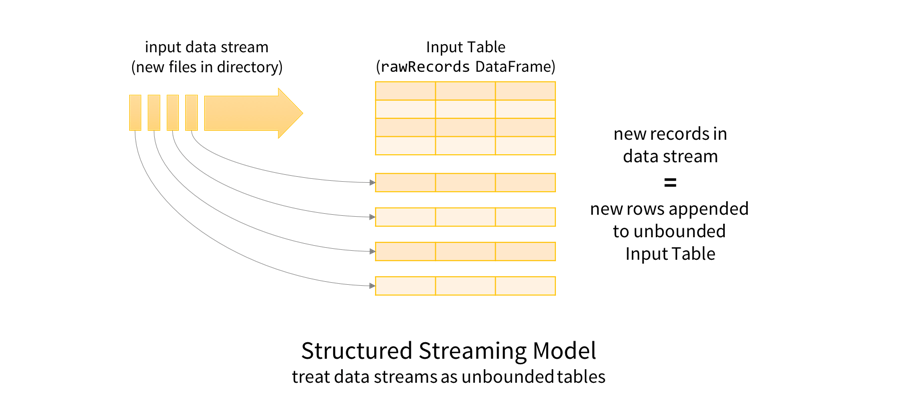

This allows us to treat both batch and streaming data as tables. Since tables and DataFrames/Datasets are semantically synonymous, the same batch-like DataFrame/Dataset queries can be applied to both batch and streaming data. In this case, we will transform the raw JSON data such that it’s easier to query using Spark SQL’s built-in support for manipulating complex nested schemas. Here is an abridged version of the transformation.

In [ ]:
cloudTrailEvents = rawRecords \
  .select(explode("Records").alias("record")) \
  .select(
    unix_timestamp("record.eventTime", "yyyy-MM-dd'T'hh:mm:ss").cast("timestamp").alias("timestamp"),
    "record.*")

Here, we explode (split) the array of records loaded from each file into separate records. We also parse the string event time string in each record to Spark’s timestamp type, and flatten out the nested columns for easier querying. Note that if cloudtrailEvents was a batch DataFrame on a fixed set of files, then we would have written the same query, and we would have written the results only once as parsed.write.parquet("/cloudtrail"). Instead, we will start a StreamingQuery that runs continuously to transform new data as it arrives.

In [ ]:
checkpointPath = "/cloudtrail.checkpoint/

streamingETLQuery = cloudTrailEvents \
  .withColumn("date", cloudTrailEvents.timestamp.cast("date")) \
  .writeStream \
  .format("parquet") \
  .option("path", parquetOutputPath) \
  .partitionBy("date") \
  .trigger(processingTime="10 seconds") \
  .option("checkpointLocation", checkpointPath) \
  .start()

Here we are specifying the following configurations for the StreamingQuery before starting it.

     1) Derive the date from the timestamp column
     2) Check for new files every 10 seconds (i.e., trigger interval)
     3) Write the transformed data from parsed DataFrame as a Parquet-formatted table at the path /cloudtrail
     4) Partition the Parquet table by date so that we can later efficiently query time slices of the data; a key requirement in monitoring applications.
     5) Save checkpoint information at the path /checkpoints/cloudtrail for fault-tolerance (explained later in the blog)

In terms of the Structured Streaming Model, this is how the execution of this query is performed.

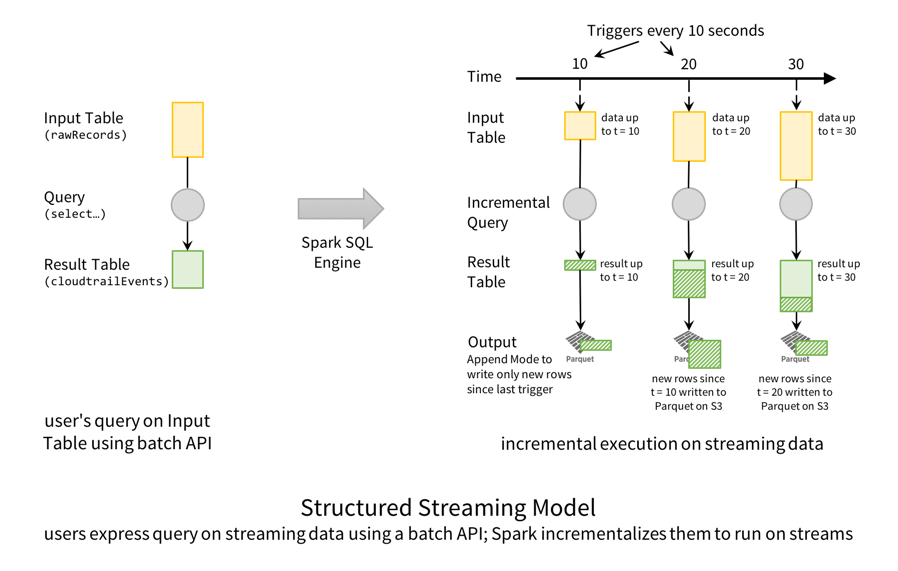

Conceptually, the rawRecords DataFrame is an append-only Input Table, and the cloudtrailEvents DataFrame is the transformed Result Table. In other words, when new rows are appended to the input (rawRecords), the result table (cloudtrailEvents) will have new transformed rows. In this particular case, every 10 seconds, Spark SQL engine triggers a check for new files. When it finds new data (i.e., new rows in the Input Table), it transforms the data to generate new rows in the Result Table, which then get written out as Parquet files.

Furthermore, while this streaming query is running, you can use Spark SQL to simultaneously query the Parquet table. The streaming query writes the Parquet data transactionally such that concurrent interactive query processing will always see a consistent view of the latest data. This strong guarantee is known as prefix-integrity and it makes Structured Streaming pipelines integrate nicely with the larger Continuous Application.

# Data Exploration using PySpark

I wouldn’t say that understanding your dataset is the most difficult thing in data science, but it is really important and time-consuming. Data Exploration is about describing the data by means of statistical and visualization techniques. We explore data in order to understand the features and bring important features to our models.

## 7.1. Univariate Analysis
In mathematics, univariate refers to an expression, equation, function or polynomial of only one variable. “Uni” means “one”, so in other words your data has only one variable. So you do not need to deal with the causes or relationships in this step. Univariate analysis takes data, summarizes that variables (attributes) one by one and finds patterns in the data.

There are many ways that can describe patterns found in univariate data include central tendency (mean, mode and median) and dispersion: range, variance, maximum, minimum, quartiles (including the interquartile range), coefficient of variation and standard deviation. You also have several options for visualizing and describing data with univariate data. Such as frequency Distribution Tables, bar Charts, histograms, frequency Polygons, pie Charts.

## 7.1.1. Numerical Variables
### 7.1.1.1. Describe

The describe function in pandas and spark will give us most of the statistical results, such as min, median, max, quartiles and standard deviation. With the help of the user defined function, you can get even more statistical results.

```
# selected varables for the demonstration
num_cols = ['Account Balance','No of dependents']
df.select(num_cols).describe().show()
```


```
+-------+------------------+-------------------+
|summary|   Account Balance|   No of dependents|
+-------+------------------+-------------------+
|  count|              1000|               1000|
|   mean|             2.577|              1.155|
| stddev|1.2576377271108936|0.36208577175319395|
|    min|                 1|                  1|
|    max|                 4|                  2|
+-------+------------------+-------------------+
```


You may find out that the default function in PySpark does not include the quartiles. The following function will help you to get the same results in Pandas

```
def describe_pd(df_in, columns, deciles=False):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    :author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]
    
```

```describe_pd(df,num_cols)```

```
+-------+------------------+-----------------+
|summary|   Account Balance| No of dependents|
+-------+------------------+-----------------+
|  count|            1000.0|           1000.0|
|   mean|             2.577|            1.155|
| stddev|1.2576377271108936|0.362085771753194|
|    min|               1.0|              1.0|
|    max|               4.0|              2.0|
|    25%|               1.0|              1.0|
|    50%|               2.0|              1.0|
|    75%|               4.0|              1.0|
+-------+------------------+-----------------+
```

Sometimes, because of the confidential data issues, you can not deliver the real data and your clients may ask more statistical results, such as deciles. You can apply the follwing function to achieve it.

``` 
describe_pd(df,num_cols,deciles=True)
```

```
+-------+------------------+-----------------+
|summary|   Account Balance| No of dependents|
+-------+------------------+-----------------+
|  count|            1000.0|           1000.0|
|   mean|             2.577|            1.155|
| stddev|1.2576377271108936|0.362085771753194|
|    min|               1.0|              1.0|
|    max|               4.0|              2.0|
|     0%|               1.0|              1.0|
|    10%|               1.0|              1.0|
|    20%|               1.0|              1.0|
|    30%|               2.0|              1.0|
|    40%|               2.0|              1.0|
|    50%|               2.0|              1.0|
|    60%|               3.0|              1.0|
|    70%|               4.0|              1.0|
|    80%|               4.0|              1.0|
|    90%|               4.0|              2.0|
|   100%|               4.0|              2.0|
+-------+------------------+-----------------+
```

## 7.1.1.2. Skewness and Kurtosis

This subsection comes from Wikipedia Skewness.

In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined.For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right.

Consider the two distributions in the figure just below. Within each graph, the values on the right side of the distribution taper differently from the values on the left side. These tapering sides are called tails, and they provide a visual means to determine which of the two kinds of skewness a distribution has:

negative skew: The left tail is longer; the mass of the distribution is concentrated on the right of the figure. The distribution is said to be left-skewed, left-tailed, or skewed to the left, despite the fact that the curve itself appears to be skewed or leaning to the right; left instead refers to the left tail being drawn out and, often, the mean being skewed to the left of a typical center of the data. A left-skewed distribution usually appears as a right-leaning curve.

positive skew: The right tail is longer; the mass of the distribution is concentrated on the left of the figure. The distribution is said to be right-skewed, right-tailed, or skewed to the right, despite the fact that the curve itself appears to be skewed or leaning to the left; right instead refers to the right tail being drawn out and, often, the mean being skewed to the right of a typical center of the data. A right-skewed distribution usually appears as a left-leaning curve.

This subsection comes from Wikipedia Kurtosis.

In probability theory and statistics, kurtosis (kyrtos or kurtos, meaning “curved, arching”) is a measure of the “tailedness” of the probability distribution of a real-valued random variable. In a similar way to the concept of skewness, kurtosis is a descriptor of the shape of a probability distribution and, just as for skewness, there are different ways of quantifying it for a theoretical distribution and corresponding ways of estimating it from a sample from a population.


```
from pyspark.sql.functions import col, skewness, kurtosis
df.select(skewness(var),kurtosis(var)).show()
```


```
+---------------------+---------------------+
|skewness(Age (years))|kurtosis(Age (years))|
+---------------------+---------------------+
|   1.0231743160548064|   0.6114371688367672|
+---------------------+---------------------+
```

### 7.1.1.3. Histogram

The fundamental difference between histogram and bar graph will help you to identify the two easily is that there are gaps between bars in a bar graph but in the histogram, the bars are adjacent to each other. The interested reader is referred to Difference Between Histogram and Bar Graph.

```
var = 'Age (years)'
x = data1[var]
bins = np.arange(0, 100, 5.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

fig.savefig(var+".pdf", bbox_inches='tight')
```

# Assesment 
## ETL Spark Streaming Development exercise